In [7]:
import os
import json
import matplotlib.pyplot as plt
import sys
# Base directory and algorithms
base_dir = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
save_dir = os.path.join(base_dir, "all_mae")
os.makedirs(save_dir, exist_ok=True)

algo_names = ["FedProx", "CFedDC", "FedDC", "FedAvg"]
num_users = 535

# Font sizes and styles
label_fontsize = 14
tick_fontsize = 12
legend_fontsize = 12

style_map = {
    "FedProx": {"color": "blue", "marker": "o"},
    "CFedDC": {"color": "green", "marker": "s"},
    "FedDC": {"color": "orange", "marker": "D"},
    "FedAvg": {"color": "purple", "marker": "v"}
}

for user_id in range(num_users):
    filename = f"user_{user_id}_val_round_results.json"

    # Check file presence
    all_exist = all(os.path.exists(os.path.join(base_dir, algo, "local_val", filename)) for algo in algo_names)
    if not all_exist:
        print(f"Skipping user_{user_id}: missing file in one or more folders.")
        continue

    info_cmae_dict = {}
    legend_labels = {}
    resource_category = "Unknown"

    for algo in algo_names:
        file_path = os.path.join(base_dir, algo, "local_val", filename)
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                info_cmae = data.get("validation_results", {}).get("info_mae", [])
                if info_cmae:
                    min_val = min(info_cmae)
                    min_idx = info_cmae.index(min_val)
                    info_cmae_dict[algo] = (info_cmae, min_val, min_idx)
                    legend_labels[algo] = f"{algo} ({min_val:.2f} @ {min_idx})"
                if algo == "CFedDC":
                    resource_category = data.get("resource_category", "Unknown").replace(" user", "")
                    #print(f"Resource category for user {user_id}: {resource_category}")
                    
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    # Plotting
    plt.figure(figsize=(10, 6))
    for algo, (cmae_list, min_val, min_idx) in info_cmae_dict.items():
        color = style_map[algo]["color"]
        marker = style_map[algo]["marker"]
        x_vals = list(range(1, len(cmae_list) + 1))

        # Line plot
        plt.plot(x_vals, cmae_list, label=legend_labels[algo], color=color)
        # Shadow under the curve
        #plt.fill_between(x_vals, cmae_list, color=color, alpha=0.1)
        # Min point
        plt.scatter(min_idx + 1, min_val, color=color, marker=marker, s=80, zorder=5)

    plt.xlabel("Rounds", fontsize=label_fontsize)
    plt.ylabel("MAE", fontsize=label_fontsize)
    plt.title(f"User ID: {user_id} | Category: {resource_category}", fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.ylim(0.0, 5.0)
    plt.grid(True)
    plt.tight_layout()

    # Save to file
    save_path = os.path.join(save_dir, f"user_{user_id}_info_mae.png")
    plt.savefig(save_path)
    plt.close()

    print(f"Saved plot: {save_path}")


Resource category for user 0: Resourceful
Saved plot: /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/user_0_info_mae.png
Resource category for user 1: Resourceful
Saved plot: /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/user_1_info_mae.png
Resource category for user 2: Resourceless
Saved plot: /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/user_2_info_mae.png
Resource category for user 3: Resourceful
Saved plot: /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/user_3_info_mae.png
Resource category for user 4: Resourceless
Saved plot: /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/user_4_info_mae.png
Skipping user_5: missing file in one or more folders.
Resource category for user 6: Resourceless
Saved plot: /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/user_6_info_mae.png
Resource category for user 7: Resourceless
Saved plot: /proj/sourasb-2205

In [19]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Base directory (same as before)
base_dir = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
algo_names = ["CFedDC", "FedDC"]
num_users = 535

# We'll store all per‐user lists in these dicts:
#   - cmae_lists["CFedDC"] will be a list of lists; each inner list is the per‐round MAE for one resourceless user.
#   - cmae_lists["FedDC"] likewise.
cmae_lists = { algo: [] for algo in algo_names }

for user_id in range(num_users):
    filename = f"user_{user_id}_val_round_results.json"

    # First check that the CFedDC file exists, because we need to read resource_category from it.
    cfeddc_path = os.path.join(base_dir, "CFedDC", "local_val", filename)
    if not os.path.exists(cfeddc_path):
        # If CFedDC JSON is missing, skip right away
        continue

    # Read CFedDC JSON to see if this user is "resourceless"
    try:
        with open(cfeddc_path, "r") as f:
            data_cf = json.load(f)
    except Exception as e:
        print(f"Error reading {cfeddc_path}: {e}")
        continue

    # Extract and normalize resource_category
    rc = data_cf.get("resource_category", "Unknown").replace(" user", "").lower()
    
    if rc != "resourceless":
        # print(f"User {user_id} resource category: {rc}")
        # Not a resourceless user -> skip
        continue

    # At this point, we know:
    #  - The user is “resourceless”
    #  - The CFedDC JSON exists and is already loaded into data_cf

    # Check that the FedDC file ALSO exists
    feddc_path = os.path.join(base_dir, "FedDC", "local_val", filename)
    if not os.path.exists(feddc_path):
        # If FedDC JSON is missing, we cannot include this user
        continue

    # Load FedDC JSON
    try:
        with open(feddc_path, "r") as f:
            data_fd = json.load(f)
    except Exception as e:
        print(f"Error reading {feddc_path}: {e}")
        continue

    # Extract per‐round MAE arrays for CFedDC and FedDC
    cmae_cf = data_cf.get("validation_results", {}).get("info_cmae", [])
    cmae_fd = data_fd.get("validation_results", {}).get("info_cmae", [])
    #print(f"User {user_id} length of CFedDC CMAE: {len(cmae_cf)}, FedDC CMAE: {len(cmae_fd)}")
    
    # If either one is empty, skip this user
    if not cmae_cf or not cmae_fd:
        continue

    # Append to our lists
    cmae_lists["CFedDC"].append(cmae_cf)
    cmae_lists["FedDC"].append(cmae_fd)
print(cmae_lists)

# -------------------------------------------------------------------
# Now we have, for each algorithm, a list of N “resourceless users,” where each entry
# is itself a list of MAE‐vs‐round. We need to average them “column‐wise” (round‐wise):
#   e.g. for round 1, average over user_i’s cmae_list[0], etc.

avg_cmae = {}

for algo in algo_names:
    all_user_lists = cmae_lists[algo]
    if len(all_user_lists) == 0:
        print(f"No resourceless users found for {algo}.")
        avg_cmae[algo] = []
        continue

    # Determine the maximum number of rounds that appear among all users of this algo
    max_rounds = max(len(lst) for lst in all_user_lists)

    # We'll build a 2D array of shape (num_users, max_rounds), filling "missing rounds" with np.nan
    mat = np.full((len(all_user_lists), max_rounds), np.nan, dtype=float)

    for i, lst in enumerate(all_user_lists):
        mat[i, : len(lst)] = lst

    # Now compute the mean across users for each round‐index, ignoring np.nan
    # result: avg_cmae[algo] is an array of length == max_rounds
    avg_cmae[algo] = np.nanmean(mat, axis=0)

# -------------------------------------------------------------------
# Plotting the two mean‐curves on a single figure

plt.figure(figsize=(8, 5))

# Plot CFedDC
if len(avg_cmae["CFedDC"]) > 0:
    rounds = np.arange(1, len(avg_cmae["CFedDC"]) + 1)
    plt.plot(
        rounds,
        avg_cmae["CFedDC"],
        label="CFedDC (mean CMAE over resourceless)",
        color="green",
        marker="s",
    )

# Plot FedDC
if len(avg_cmae["FedDC"]) > 0:
    rounds = np.arange(1, len(avg_cmae["FedDC"]) + 1)
    plt.plot(
        rounds,
        avg_cmae["FedDC"],
        label="FedDC (mean CMAE over resourceless)",
        color="orange",
        marker="D",
    )

plt.xlabel("Round", fontsize=14)
plt.ylabel("Average MAE", fontsize=14)
plt.title("Mean CMAE per Round — Resourceless Users (Algo Comparison)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(0.0, 5.0)      # same y‐limit as before
plt.tight_layout()

# Where to save:
save_path = os.path.join(base_dir, "all_mae", "resourceless_mean_cmae_FedDC_vs_CFedDC.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.close()

print(f"Saved comparison plot for resourceless users at:\n    {save_path}")


{'CFedDC': [[4.265233993530273, 4.843130677938461, 0.12494754791259766, 2.9044408798217773, 4.446619510650635, 4.839928448200226, 0.16597366333007812, 2.855210304260254, 3.2286882400512695, 0.9914946556091309, 3.2295857667922974, 0.3879566192626953, 3.0116519927978516, 1.6207046508789062, 5.0, 1.7316632270812988, 0.6898770332336426, 1.3663523197174072, 3.064654588699341, 1.0154187679290771, 0.07510662078857422, 0.6503071784973145, 1.1654884815216064, 1.385085105895996, 5.0, 1.553184986114502, 3.896452307701111, 0.8458595275878906, 0.4500422477722168, 4.58520781993866], [0.29213619232177734, 0.296244740486145, 0.24961018562316895, 0.32352542877197266, 0.3001875877380371, 0.8420496582984924, 2.9671547412872314, 0.29350292682647705, 0.40536391735076904, 4.541989803314209, 3.2362070083618164, 9.15622329711914, 0.15602999925613403, 4.699307441711426, 0.5671541690826416, 5.721744537353516, 5.224797248840332, 1.1883983612060547, 3.09489107131958, 0.538749098777771, 0.8081436157226562, 2.39516

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Base directory (same as before)
base_dir = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
algo_names = ["CFedDC", "FedDC", "FedMEM"]
num_users = 535

# We'll store all per‐user lists in these dicts:
#   cmae_lists["CFedDC"] = [ [user1_round1, user1_round2, ...], [user2_round1, ...], ... ]
#   cmae_lists["FedDC"]  = [ [user1_round1, user1_round2, ...], [user2_round1, ...], ... ]
cmae_lists = { algo: [] for algo in algo_names }

for user_id in range(num_users):
    filename = f"user_{user_id}_val_round_results.json"

    # 1) Read CFedDC JSON to filter by "resourceless"
    cfeddc_path = os.path.join(base_dir, "CFedDC", "local_test", filename)
    if not os.path.exists(cfeddc_path):
        continue

    try:
        with open(cfeddc_path, "r") as f:
            data_cf = json.load(f)
    except Exception as e:
        print(f"Error reading {cfeddc_path}: {e}")
        continue

    rc = data_cf.get("resource_category", "Unknown").replace(" user", "").lower()
    if rc != "resourceless":
        continue

    # 2) Make sure FedDC JSON also exists
    feddc_path = os.path.join(base_dir, "FedDC", "local_test", filename)
    if not os.path.exists(feddc_path):
        continue

    try:
        with open(feddc_path, "r") as f:
            data_fd = json.load(f)
    except Exception as e:
        print(f"Error reading {feddc_path}: {e}")
        continue

    fedmem_path = os.path.join(base_dir, "FedMEM", "local_test", filename)
    try:
        with open(fedmem_path, "r") as f:
            data_cf = json.load(f)
    except Exception as e:
        print(f"Error reading {cfeddc_path}: {e}")
        continue


    # 3) Extract per‐round CMAE for both algorithms
    cmae_cf = data_cf.get("validation_results", {}).get("info_cmae", [])
    cmae_fd = data_fd.get("validation_results", {}).get("info_cmae", [])

    if not cmae_cf or not cmae_fd:
        continue

    cmae_lists["CFedDC"].append(cmae_cf)
    cmae_lists["FedDC"].append(cmae_fd)

# -------------------------------------------------------------------
# Now convert each algorithm’s list of lists into a 2D NumPy array
# with shape (num_resourceless_users, max_rounds), filling missing entries with np.nan.

matrices = {}   # will hold the 2D arrays
round_counts = {}  # will hold max_rounds per algorithm

for algo in algo_names:
    all_user_lists = cmae_lists[algo]
    if len(all_user_lists) == 0:
        print(f"No resourceless users found for {algo}.")
        matrices[algo] = np.empty((0,0))
        round_counts[algo] = 0
        continue

    max_rounds = max(len(lst) for lst in all_user_lists)
    round_counts[algo] = max_rounds

    mat = np.full((len(all_user_lists), max_rounds), np.nan, dtype=float)
    for i, lst in enumerate(all_user_lists):
        mat[i, : len(lst)] = lst

    matrices[algo] = mat

# -------------------------------------------------------------------
# 1) Plot “mean CMAE per round” line chart (as before):

avg_cmae = {}
for algo in algo_names:
    mat = matrices[algo]
    if mat.size == 0:
        avg_cmae[algo] = np.array([])
    else:
        avg_cmae[algo] = np.nanmean(mat, axis=0)

plt.figure(figsize=(8, 5))

# CFedDC mean line
if avg_cmae["CFedDC"].size > 0:
    rounds_cf = np.arange(1, len(avg_cmae["CFedDC"]) + 1)
    plt.plot(
        rounds_cf,
        avg_cmae["CFedDC"],
        label="CFedDC (mean CMAE)",
        color="green",
        marker="s",
    )

# FedDC mean line
if avg_cmae["FedDC"].size > 0:
    rounds_fd = np.arange(1, len(avg_cmae["FedDC"]) + 1)
    plt.plot(
        rounds_fd,
        avg_cmae["FedDC"],
        label="FedDC (mean CMAE)",
        color="orange",
        marker="D",
    )

plt.xlabel("Round", fontsize=14)
plt.ylabel("Average CMAE", fontsize=14)
plt.title("Mean CMAE per Round — Resourceless Users", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(0.0, 50.0)
plt.tight_layout()

save_mean = os.path.join(base_dir, "all_mae", "resourceless_mean_cmae_FedDC_vs_CFedDC.png")
os.makedirs(os.path.dirname(save_mean), exist_ok=True)
plt.savefig(save_mean)
plt.close()
print(f"Saved mean‐curve plot at:\n    {save_mean}")

# -------------------------------------------------------------------
# 2) Box‐plot for CFedDC: one box per round, showing the CMAE distribution across users

if matrices["CFedDC"].size > 0:
    mat_cf = matrices["CFedDC"]  # shape = (num_users_cf, max_rounds_cf)
    max_rounds_cf = round_counts["CFedDC"]

    # Prepare data for boxplot: a list of length=max_rounds_cf,
    # where each element is the array of non‐nan CMAE values for that round.
    box_data_cf = []
    for r in range(max_rounds_cf):
        col_vals = mat_cf[:, r]
        non_nan = col_vals[~np.isnan(col_vals)]
        box_data_cf.append(non_nan)

    plt.figure(figsize=(10, 6))
    plt.boxplot(
        box_data_cf,
        positions=np.arange(1, max_rounds_cf + 1),
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor="lightgreen", edgecolor="green"),
        medianprops=dict(color="darkgreen"),
    )
    plt.xlabel("Round", fontsize=14)
    plt.ylabel("CMAE", fontsize=14)
    plt.title("CFedDC CMAE Distribution per Round (Resourceless Users)", fontsize=14)
    plt.xticks(np.arange(1, max_rounds_cf + 1), fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0.0, 50.0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    save_box_cf = os.path.join(base_dir, "all_mae", "boxplot_CFedDC_resourceless.png")
    plt.savefig(save_box_cf)
    plt.close()
    print(f"Saved CFedDC box plot at:\n    {save_box_cf}")
else:
    print("Skipping CFedDC box plot (no data).")

# -------------------------------------------------------------------
# 3) Box‐plot for FedDC: one box per round, showing the CMAE distribution across users

if matrices["FedDC"].size > 0:
    mat_fd = matrices["FedDC"]  # shape = (num_users_fd, max_rounds_fd)
    max_rounds_fd = round_counts["FedDC"]

    box_data_fd = []
    for r in range(max_rounds_fd):
        col_vals = mat_fd[:, r]
        non_nan = col_vals[~np.isnan(col_vals)]
        box_data_fd.append(non_nan)

    plt.figure(figsize=(10, 6))
    plt.boxplot(
        box_data_fd,
        positions=np.arange(1, max_rounds_fd + 1),
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor="moccasin", edgecolor="orange"),
        medianprops=dict(color="darkorange"),
    )
    plt.xlabel("Round", fontsize=14)
    plt.ylabel("CMAE", fontsize=14)
    plt.title("FedDC CMAE Distribution per Round (Resourceless Users)", fontsize=14)
    plt.xticks(np.arange(1, max_rounds_fd + 1), fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0.0, 50.0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    save_box_fd = os.path.join(base_dir, "all_mae", "boxplot_FedDC_resourceless.png")
    plt.savefig(save_box_fd)
    plt.close()
    print(f"Saved FedDC box plot at:\n    {save_box_fd}")
else:
    print("Skipping FedDC box plot (no data).")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No resourceless users found for CFedDC.
No resourceless users found for FedDC.
No resourceless users found for FedMEM.
Saved mean‐curve plot at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceless_mean_cmae_FedDC_vs_CFedDC.png
Skipping CFedDC box plot (no data).
Skipping FedDC box plot (no data).


Number of rounds to plot: 30


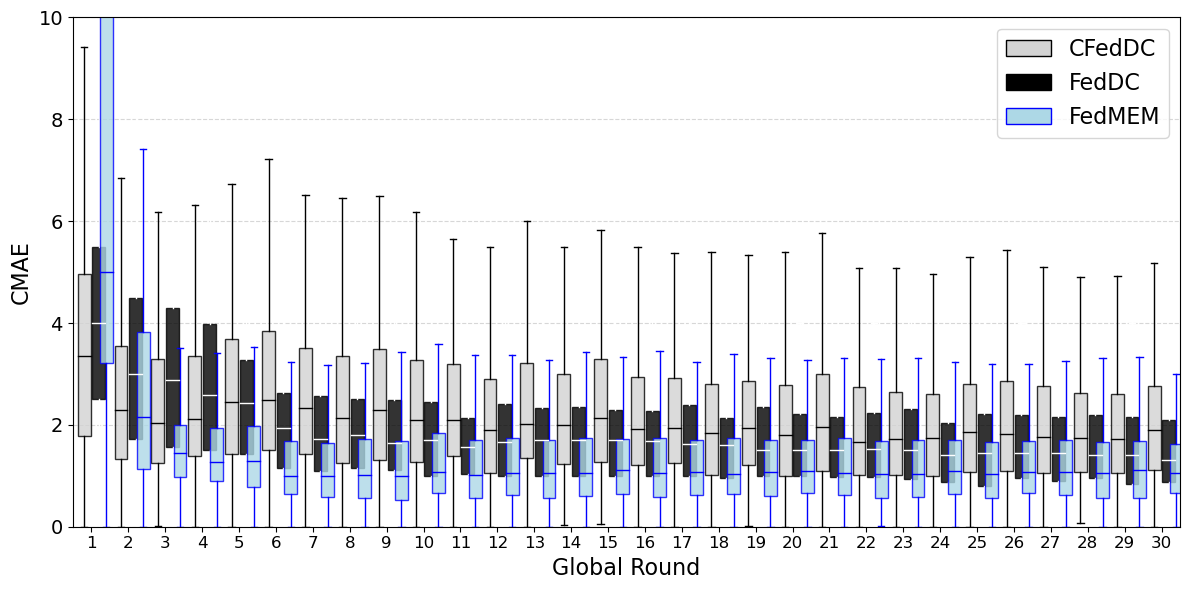

Saved boxplot comparison (grey & black) at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceless_boxplot_FedDC_vs_CFedDC_vs_FedMEM_grey_black.png


In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
algos     = ["CFedDC", "FedMEM", "FedDC"]
num_users = 535

# Prepare containers to hold each “resourceless” user’s per-round CMAE lists:
cmae_lists = { algo: [] for algo in algos }

# ─── STEP 1: COLLECT “RESOURCELESS” USERS’ CMAE DATA ───────────────────────────
for user_id in range(num_users):
    filename     = f"user_{user_id}_test_round_results.json"
    cfeddc_path  = os.path.join(base_dir, "CFedDC", "local_test", filename)
    fedmem_path  = os.path.join(base_dir, "FedMEM", "local_test", filename)
    feddc_path   = os.path.join(base_dir, "FedDC",  "local_test", filename)

    # 1a) Must have CFedDC JSON so we can check the resource_category
    if not os.path.exists(cfeddc_path):
        continue

    try:
        with open(cfeddc_path, "r") as f:
            data_cf = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {cfeddc_path}: {e}")
        continue

    # 1b) Only keep users whose resource_category == "resourceless"
    # rc = data_cf.get("resource_category", "Unknown").replace(" user", "").lower()
    # if rc != "resourceless":
    #     continue

    # 1c) Now ensure FedDC JSON also exists
    if not os.path.exists(feddc_path):
        continue

    try:
        with open(feddc_path, "r") as f:
            data_fd = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {feddc_path}: {e}")
        continue

    # 1c) Now ensure FedMEM JSON also exists
    if not os.path.exists(fedmem_path):
        continue

    try:
        with open(fedmem_path, "r") as f:
            data_fm = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {fedmem_path}: {e}")
        continue

    # 1d) Extract per-round CMAE (key is "info_cmae")
    cmae_cf = data_cf.get("validation_results", {}).get("info_cmae", [])
    cmae_fm = data_fm.get("validation_results", {}).get("info_cmae", [])
    cmae_fd = data_fd.get("validation_results", {}).get("info_cmae", [])

    # Skip if either list is empty
    if not cmae_cf or not cmae_fd or not cmae_fm: 
        continue

    # 1e) Append each user's CMAE list to the respective algorithm's container
    cmae_lists["CFedDC"].append(cmae_cf)
    cmae_lists["FedDC"].append(cmae_fd)
    cmae_lists["FedMEM"].append(cmae_fm)

# ─── STEP 2: ORGANIZE DATA “BY ROUND” ───────────────────────────────────────────
# Ensure we found at least one resourceless user for each algorithm
if len(cmae_lists["CFedDC"]) == 0 or len(cmae_lists["FedDC"]) == 0 or len(cmae_lists["FedMEM"]) == 0:
    raise RuntimeError("No resourceless users found for CFedDC, FedMEM and/or FedDC.")

# Find the maximum number of rounds across all resourceless users for each algorithm
max_rounds_cf = max(len(lst) for lst in cmae_lists["CFedDC"])
max_rounds_fd = max(len(lst) for lst in cmae_lists["FedDC"])
max_rounds_fm = max(len(lst) for lst in cmae_lists["FedMEM"])

# We only want to plot up to the minimum of these two maxima,
# so that both algorithms have data for each round we show.
common_rounds = min(max_rounds_cf, max_rounds_fd, max_rounds_fm, 30)

# Create lists of length common_rounds; each inner list accumulates all CMAE values at that round
cf_by_round = [[] for _ in range(common_rounds)]
fd_by_round = [[] for _ in range(common_rounds)]
fm_by_round = [[] for _ in range(common_rounds)]

# Populate cf_by_round
for user_list in cmae_lists["CFedDC"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            cf_by_round[r].append(user_list[r])

# Populate fd_by_round
for user_list in cmae_lists["FedDC"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            fd_by_round[r].append(user_list[r])

# Populate fm_by_round
for user_list in cmae_lists["FedMEM"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            fm_by_round[r].append(user_list[r])

# ─── STEP 3: DRAW GROUPED BOXPLOTS IN ONE FIGURE (GREY & BLACK) ───────────────
plt.figure(figsize=(12, 6))

# X positions: 1, 2, …, common_rounds
rounds = np.arange(1, common_rounds + 1)
print(f"Number of rounds to plot: {common_rounds}")
offset = 0.20  # horizontal shift so boxes don't overlap exactly

# Positions for CFedDC and FedDC boxes
pos_cf = rounds - offset
pos_fd = rounds + offset
pos_fm = rounds + 2 * offset  # For FedMEM, if needed

# 3a) CFedDC boxplot (light grey fill, black edges & median)
plt.boxplot(
    cf_by_round,
    positions=pos_cf,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="lightgrey", edgecolor="black", alpha=0.8),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markeredgecolor="black"),
)

# 3b) FedDC boxplot (black fill, white median & white whiskers)
plt.boxplot(
    fd_by_round,
    positions=pos_fd,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="black", edgecolor="black", alpha=0.8),
    medianprops=dict(color="white"),
    whiskerprops=dict(color="white"),
    capprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white"),
)

# 3c) FedMEM boxplot (optional, if you want to include it)
plt.boxplot(
    fm_by_round,
    positions=pos_fm,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="lightblue", edgecolor="blue", alpha=0.8),
    medianprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    capprops=dict(color="blue"),
    flierprops=dict(markeredgecolor="blue"),
)

# 3c) Force x-axis ticks to be exactly at 1, 2, …, common_rounds
plt.xticks(
    rounds,                          # tick locations
    [str(r) for r in rounds],       # tick labels
    fontsize=12
)
plt.xlim(0.5, common_rounds + 0.5)  # ensure the first and last boxes are fully visible

# 3d) Labels, title, and grid
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("CMAE", fontsize=16)
#plt.title("Resourceless Users: CMAE Distribution per Round\n(CFedDC vs. FedDC)", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0,10.0)                  # keep the same y-limit
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 3e) Custom legend (grey = CFedDC, black = FedDC)
import matplotlib.patches as mpatches
patch_cf = mpatches.Patch(facecolor="lightgrey", edgecolor="black", label="CFedDC")
patch_fd = mpatches.Patch(facecolor="black", edgecolor="black", label="FedDC")
patch_fm = mpatches.Patch(facecolor="lightblue", edgecolor="blue", label="FedMEM")
plt.legend(handles=[patch_cf, patch_fd, patch_fm], fontsize=16, loc="upper right")

plt.tight_layout()

# 3f) Save the figure
save_path = os.path.join(base_dir, "all_mae", "resourceless_boxplot_FedDC_vs_CFedDC_vs_FedMEM_grey_black.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()  # Show the plot in the notebook (optional)
plt.close()

print(f"Saved boxplot comparison (grey & black) at:\n    {save_path}")


Processing folder: CFedDC_lambda_0.0_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.2_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.4_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.6_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.8_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_1.0_kappa_1.0_delta_1.0
Common rounds across folders: 30


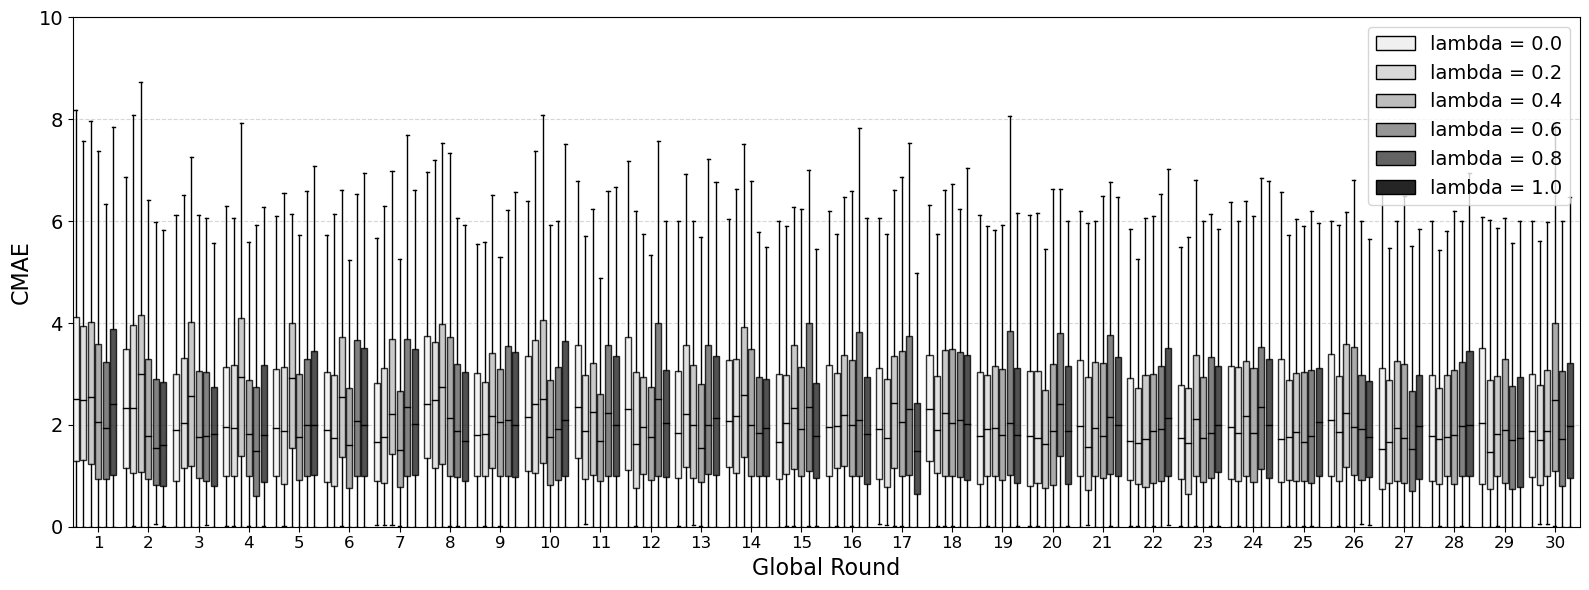

Saved boxplot comparison at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceless_boxplot_CFedDC_lambdas_grey.png


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

folders   = [
    "CFedDC_lambda_0.0_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.2_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.4_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.6_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.8_kappa_1.0_delta_1.0",
    "CFedDC_lambda_1.0_kappa_1.0_delta_1.0"
]

num_users = 535

# ─── STEP 1: COLLECT DATA ──────────────────────────────────────────────────────
# For each variant, prepare a list of resourceless users' CMAE lists
cmae_lists = { folder: [] for folder in folders }

for folder in folders:
    print(f"Processing folder: {folder}")
    for user_id in range(num_users):
        filename = f"user_{user_id}_val_round_results.json"
        file_path = os.path.join(base_dir, folder, "local_val", filename)

        if not os.path.exists(file_path):
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Warning] Could not read {file_path}: {e}")
            continue

        # Only keep "resourceless" users
        rc = data.get("resource_category", "Unknown").replace(" user", "").lower()
        if rc != "resourceless":
            continue

        # Extract CMAE list
        cmae = data.get("validation_results", {}).get("info_cmae", [])
        if not cmae:
            continue

        # Append this user's CMAE list
        cmae_lists[folder].append(cmae)

# ─── STEP 2: ORGANIZE DATA BY ROUND ────────────────────────────────────────────
# Ensure we found some users
for folder in folders:
    if len(cmae_lists[folder]) == 0:
        raise RuntimeError(f"No resourceless users found for {folder}.")

# Find the common number of rounds
max_rounds_per_folder = [max(len(lst) for lst in cmae_lists[folder]) for folder in folders]
common_rounds = min(max_rounds_per_folder)
print(f"Common rounds across folders: {common_rounds}")

# Create lists of length common_rounds for each folder
by_round = {}
for folder in folders:
    by_round[folder] = [[] for _ in range(common_rounds)]
    for user_list in cmae_lists[folder]:
        for r in range(len(user_list)):
            if r < common_rounds:
                by_round[folder][r].append(user_list[r])

# ─── STEP 3: PLOT ──────────────────────────────────────────────────────────────
plt.figure(figsize=(16, 6))

rounds = np.arange(1, common_rounds + 1)
offset = 0.15  # smaller offset since we now have 6 groups
width  = 0.12  # narrower width so boxes don't overlap

# Define 6 shades of grey
colors = ["#f0f0f0", "#d9d9d9", "#bdbdbd", "#969696", "#636363", "#252525"]

# Plot each folder
for idx, folder in enumerate(folders):
    pos = rounds + (idx - len(folders) / 2) * offset
    plt.boxplot(
        by_round[folder],
        positions=pos,
        widths=width,
        patch_artist=True,
        showfliers=False,
        boxprops=dict(facecolor=colors[idx], edgecolor="black", alpha=0.8),
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )

# X-axis ticks
plt.xticks(rounds, [str(r) for r in rounds], fontsize=12)
plt.xlim(0.5, common_rounds + 0.5)

# Labels
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("CMAE", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0, 10.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend: cleaner labels ("lambda = X.X")
patches = []
for idx, folder in enumerate(folders):
    # Extract lambda value from folder name
    lambda_str = folder.split("_")[2].replace("lambda_", "")
    label = f"lambda = {lambda_str}"
    patches.append(mpatches.Patch(facecolor=colors[idx], edgecolor="black", label=label))

plt.legend(handles=patches, fontsize=14, loc="upper right")

plt.tight_layout()

# Save
save_path = os.path.join(base_dir, "all_mae", "resourceless_boxplot_CFedDC_lambdas_grey.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved boxplot comparison at:\n    {save_path}")


Processing folder: CFedDC_lambda_0.0_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.2_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.4_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.6_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.8_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_1.0_kappa_1.0_delta_1.0
Common rounds across folders: 30
Plotting full range: 10 rounds


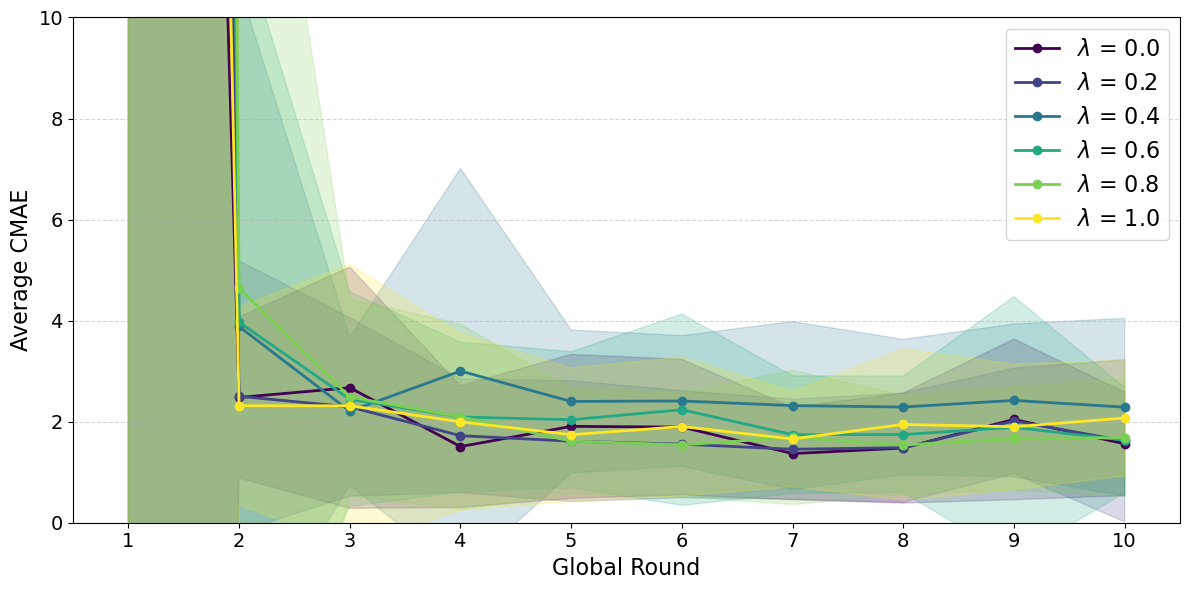

Saved lineplot of average CMAE with std shading (RESOURCEFUL ONLY) at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceful_avg_cmae_CFedDC_lambda_0_0.6_1_lineplot_minround_STD.png


In [36]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

folders   = [
    "CFedDC_lambda_0.0_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.2_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.4_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.6_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.8_kappa_1.0_delta_1.0",
    "CFedDC_lambda_1.0_kappa_1.0_delta_1.0"
]

num_users = 535

# ─── STEP 1: COLLECT DATA ──────────────────────────────────────────────────────
cmae_lists = { folder: [] for folder in folders }

for folder in folders:
    print(f"Processing folder: {folder}")
    for user_id in range(num_users):
        filename = f"user_{user_id}_val_round_results.json"
        file_path = os.path.join(base_dir, folder, "local_val", filename)
        print
        if not os.path.exists(file_path):
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Warning] Could not read {file_path}: {e}")
            continue

        rc = data.get("resource_category", "Unknown").replace(" user", "").lower()
        if rc != "resourceful":
            continue

        cmae = data.get("validation_results", {}).get("info_cmae", [])
        if not cmae:
            continue

        cmae_lists[folder].append(cmae)

# ─── STEP 2: ORGANIZE DATA BY ROUND ────────────────────────────────────────────
for folder in folders:
    if len(cmae_lists[folder]) == 0:
        raise RuntimeError(f"No resourceful users found for {folder}.")

max_rounds_per_folder = [max(len(lst) for lst in cmae_lists[folder]) for folder in folders]
common_rounds = min(max_rounds_per_folder)
print(f"Common rounds across folders: {common_rounds}")

plot_rounds = min(common_rounds, 10)
print(f"Plotting full range: {plot_rounds} rounds")

by_round = {}
for folder in folders:
    by_round[folder] = [[] for _ in range(common_rounds)]
    for user_list in cmae_lists[folder]:
        for r in range(len(user_list)):
            if r < common_rounds:
                by_round[folder][r].append(user_list[r])

# ─── STEP 3: PLOT AVERAGE CMAE + STD SHADING ───────────────────────────────────
plt.figure(figsize=(12, 6))

rounds = np.arange(1, plot_rounds + 1)

# Use a nice colormap → Viridis, one color per folder
cmap = plt.get_cmap("viridis")
n = len(folders)
colors = [cmap(i/(n-1)) for i in range(n)]

for idx, folder in enumerate(folders):
    avg_cmae = []
    std_cmae = []
    for r in range(plot_rounds):
        round_values = by_round[folder][r]
        mean_val = np.mean(round_values)
        std_val  = np.std(round_values)
        avg_cmae.append(mean_val)
        std_cmae.append(std_val)

    min_cmae = min(avg_cmae)
    min_round = avg_cmae.index(min_cmae) + 1

    lambda_val = folder.split('_')[2].replace('lambda_', '')
    label = f"$\lambda$ = {lambda_val}" # → min CMAE = {min_cmae:.3f} @ round {min_round}"

    # Plot average line
    plt.plot(
        rounds,
        avg_cmae,
        label=label,
        color=colors[idx],
        linewidth=2,
        marker='o', markersize=6
    )

    # Plot std shading
    avg_cmae = np.array(avg_cmae)
    std_cmae = np.array(std_cmae)
    plt.fill_between(
        rounds,
        avg_cmae - std_cmae,
        avg_cmae + std_cmae,
        color=colors[idx],
        alpha=0.2
    )

# X-axis
plt.xticks(rounds, [str(r) for r in rounds], fontsize=14)
plt.xlim(0.5, plot_rounds + 0.5)

# Labels
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("Average CMAE", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0, 10.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(fontsize=16, loc="upper right")

plt.tight_layout()

# Save
save_path = os.path.join(base_dir, "all_mae", "resourceful_avg_cmae_CFedDC_lambda_0_0.6_1_lineplot_minround_STD.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved lineplot of average CMAE with std shading (RESOURCEFUL ONLY) at:\n    {save_path}")


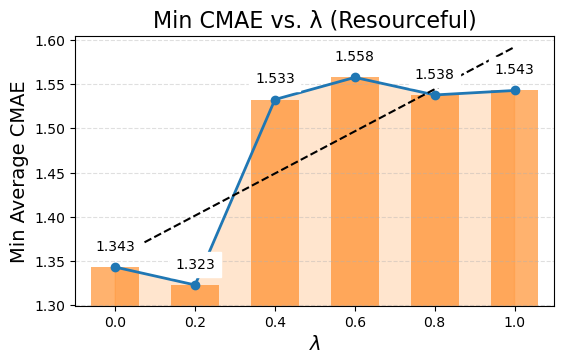

In [20]:
# ─── STEP 4: PLOT MIN CMAE VS LAMBDA WITH BAR, LINE & TREND ─────────────────

# (1) Build arrays
lambda_vals = []
min_cmaes   = []
for folder in folders:
    avg_cmae = [np.mean(by_round[folder][r]) for r in range(plot_rounds)]
    if not avg_cmae:
        continue
    lambda_vals.append(float(folder.split('_')[2].replace('lambda_', '')))
    min_cmaes.append(min(avg_cmae))

lambda_vals = np.array(lambda_vals)
min_cmaes   = np.array(min_cmaes)
idx = np.argsort(lambda_vals)
lambda_vals = lambda_vals[idx]
min_cmaes   = min_cmaes[idx]

# (2) Fit trend if possible
if len(lambda_vals) > 1:
    coef  = np.polyfit(lambda_vals, min_cmaes, 1)
    trend = np.poly1d(coef)
    x_fit = np.linspace(lambda_vals.min(), lambda_vals.max(), 100)
    y_fit = trend(x_fit)

fig, ax = plt.subplots(figsize=(6,4))

# (3) Bar chart of minima
bar_width = (lambda_vals[1] - lambda_vals[0]) * 0.6
ax.bar(lambda_vals, min_cmaes,
       width=bar_width, color='C1', alpha=0.6,
       label='Min CMAE (bar)')

# (4) Line connecting minima
ax.plot(lambda_vals, min_cmaes,
        marker='o', color='C0', linewidth=2,
        label='Min CMAE (line)')

# (5) Shaded under the line
ax.fill_between(lambda_vals, min_cmaes, 0,
                color='C1', alpha=0.2)

# (6) Trendline overlay
if len(lambda_vals) > 1:
    ax.plot(x_fit, y_fit,
            linestyle='--', color='black', linewidth=1.5,
            label=f'Trend: y={coef[0]:.2f}x+{coef[1]:.2f}')
xmin, xmax = lambda_vals.min(), lambda_vals.max()
pad = (xmax - xmin) * 0.1
ax.set_xlim(xmin - pad, xmax + pad)

# Or add a small padding around your data:
ymin, ymax = min_cmaes.min(), min_cmaes.max()
ypad = (ymax - ymin) * 0.1
ax.set_ylim(ymin - ypad, ymax + ypad*2)


# (7) Annotations
for x, y in zip(lambda_vals, min_cmaes):
    ax.annotate(f"{y:.3f}",
                xy=(x, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=10,
                backgroundcolor='white',
                clip_on=False)

# (8) Final styling
ax.set_xlabel(r'$\lambda$', fontsize=14)
ax.set_ylabel('Min Average CMAE', fontsize=14)
ax.set_title('Min CMAE vs. λ (Resourceful)', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.4)
# ax.legend(fontsize=10)
ax.margins(x=0.05, y=0.1)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(base_dir, "all_mae", "min_cmae_vs_lambda_resourceful.png"), dpi=300)
plt.show()


Processing folder: CFedDC_lambda_0.0_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.2_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.4_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.6_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.8_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_1.0_kappa_1.0_delta_1.0
Common rounds across folders: 30
Plotting full range: 10 rounds


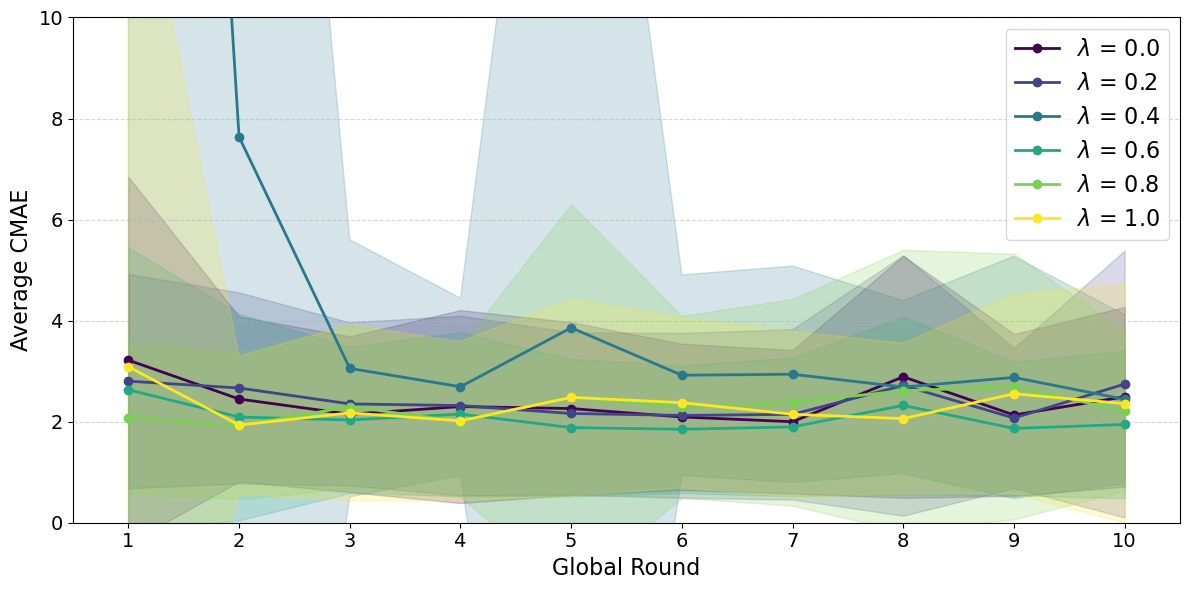

Saved lineplot of average CMAE with std shading (RESOURCELESS ONLY) at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceless_avg_cmae_CFedDC_lambda_0_0.6_1_lineplot_minround_STD.png


In [35]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

folders   = [
    "CFedDC_lambda_0.0_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.2_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.4_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.6_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.8_kappa_1.0_delta_1.0",
    "CFedDC_lambda_1.0_kappa_1.0_delta_1.0"
]

num_users = 535

# ─── STEP 1: COLLECT DATA ──────────────────────────────────────────────────────
cmae_lists = { folder: [] for folder in folders }

for folder in folders:
    print(f"Processing folder: {folder}")
    for user_id in range(num_users):
        filename = f"user_{user_id}_val_round_results.json"
        file_path = os.path.join(base_dir, folder, "local_val", filename)

        if not os.path.exists(file_path):
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Warning] Could not read {file_path}: {e}")
            continue

        # RESOURCELESS ONLY
        rc = data.get("resource_category", "Unknown").replace(" user", "").lower()
        if rc != "resourceless":
            continue

        cmae = data.get("validation_results", {}).get("info_cmae", [])
        if not cmae:
            continue

        cmae_lists[folder].append(cmae)

# ─── STEP 2: ORGANIZE DATA BY ROUND ────────────────────────────────────────────
for folder in folders:
    if len(cmae_lists[folder]) == 0:
        raise RuntimeError(f"No resourceless users found for {folder}.")

max_rounds_per_folder = [max(len(lst) for lst in cmae_lists[folder]) for folder in folders]
common_rounds = min(max_rounds_per_folder)
print(f"Common rounds across folders: {common_rounds}")

plot_rounds = min(common_rounds, 10)
print(f"Plotting full range: {plot_rounds} rounds")

by_round = {}
for folder in folders:
    by_round[folder] = [[] for _ in range(common_rounds)]
    for user_list in cmae_lists[folder]:
        for r in range(len(user_list)):
            if r < common_rounds:
                by_round[folder][r].append(user_list[r])

# ─── STEP 3: PLOT AVERAGE CMAE + STD SHADING ───────────────────────────────────
plt.figure(figsize=(12, 6))

rounds = np.arange(1, plot_rounds + 1)

# Use a nice colormap → Viridis, one color per folder
cmap = plt.get_cmap("viridis")
n = len(folders)
colors = [cmap(i/(n-1)) for i in range(n)]

for idx, folder in enumerate(folders):
    avg_cmae = []
    std_cmae = []
    for r in range(plot_rounds):
        round_values = by_round[folder][r]
        mean_val = np.mean(round_values)
        std_val  = np.std(round_values)
        avg_cmae.append(mean_val)
        std_cmae.append(std_val)

    min_cmae = min(avg_cmae)
    min_round = avg_cmae.index(min_cmae) + 1

    lambda_val = folder.split('_')[2].replace('lambda_', '')
    label = f"$\lambda$ = {lambda_val}" # → min CMAE = {min_cmae:.3f} @ round {min_round}"

    # Plot average line
    plt.plot(
        rounds,
        avg_cmae,
        label=label,
        color=colors[idx],
        linewidth=2,
        marker='o', markersize=6
    )

    # Plot std shading
    avg_cmae = np.array(avg_cmae)
    std_cmae = np.array(std_cmae)
    plt.fill_between(
        rounds,
        avg_cmae - std_cmae,
        avg_cmae + std_cmae,
        color=colors[idx],
        alpha=0.2
    )

# X-axis
plt.xticks(rounds, [str(r) for r in rounds], fontsize=14)
plt.xlim(0.5, plot_rounds + 0.5)

# Labels
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("Average CMAE", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0, 10.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(fontsize=16, loc="upper right")

plt.tight_layout()

# Save
save_path = os.path.join(base_dir, "all_mae", "resourceless_avg_cmae_CFedDC_lambda_0_0.6_1_lineplot_minround_STD.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved lineplot of average CMAE with std shading (RESOURCELESS ONLY) at:\n    {save_path}")


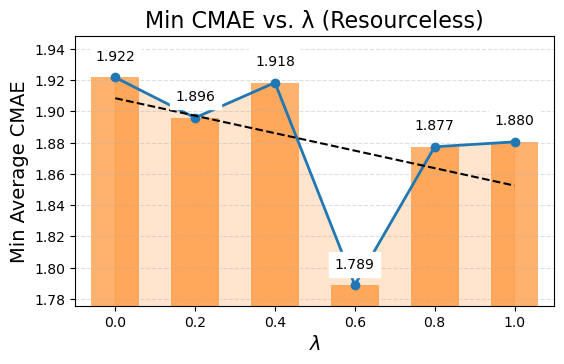

In [31]:
# ─── STEP 4: PLOT MIN CMAE VS LAMBDA WITH BAR, LINE & TREND ─────────────────

# (1) Build arrays
lambda_vals = []
min_cmaes   = []
for folder in folders:
    avg_cmae = [np.mean(by_round[folder][r]) for r in range(plot_rounds)]
    if not avg_cmae:
        continue
    lambda_vals.append(float(folder.split('_')[2].replace('lambda_', '')))
    min_cmaes.append(min(avg_cmae))

lambda_vals = np.array(lambda_vals)
min_cmaes   = np.array(min_cmaes)
idx = np.argsort(lambda_vals)
lambda_vals = lambda_vals[idx]
min_cmaes   = min_cmaes[idx]

# (2) Fit trend if possible
if len(lambda_vals) > 1:
    coef  = np.polyfit(lambda_vals, min_cmaes, 1)
    trend = np.poly1d(coef)
    x_fit = np.linspace(lambda_vals.min(), lambda_vals.max(), 100)
    y_fit = trend(x_fit)

fig, ax = plt.subplots(figsize=(6,4))

# (3) Bar chart of minima
bar_width = (lambda_vals[1] - lambda_vals[0]) * 0.6
ax.bar(lambda_vals, min_cmaes,
       width=bar_width, color='C1', alpha=0.6)
       # , label='Min CMAE (bar)')

# (4) Line connecting minima
ax.plot(lambda_vals, min_cmaes,
        marker='o', color='C0', linewidth=2)
        # , label='Min CMAE (line)')

# (5) Shaded under the line
ax.fill_between(lambda_vals, min_cmaes, 0,
                color='C1', alpha=0.2)

# (6) Trendline overlay
if len(lambda_vals) > 1:
    ax.plot(x_fit, y_fit,
            linestyle='--', color='black', linewidth=1.5)
    # ,label=f'Trend: y={coef[0]:.2f}x+{coef[1]:.2f}')

xmin, xmax = lambda_vals.min(), lambda_vals.max()
pad = (xmax - xmin) * 0.1
ax.set_xlim(xmin - pad, xmax + pad)

# Or add a small padding around your data:
ymin, ymax = min_cmaes.min(), min_cmaes.max()
ypad = (ymax - ymin) * 0.1
ax.set_ylim(ymin - ypad, ymax + ypad*2)

# (7) Annotations
for x, y in zip(lambda_vals, min_cmaes):
    ax.annotate(f"{y:.3f}",
                xy=(x, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=10,
                backgroundcolor='white',
                clip_on=False)

# (8) Final styling
ax.set_xlabel(r'$\lambda$', fontsize=14)
ax.set_ylabel('Min Average CMAE', fontsize=14)
ax.set_title('Min CMAE vs. λ (Resourceless)', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.4)
# ax.legend(fontsize=10)
ax.margins(x=0.05, y=0.3)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(base_dir, "all_mae", "min_cmae_vs_lambda_resourceless.png"))
plt.show()



Processing folder: CFedDC_lambda_0.0_kappa_1.0_delta_1.0


Processing folder: CFedDC_lambda_0.2_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.4_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_0.8_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_1.0_kappa_1.0_delta_1.0
Common rounds across folders: 30
Plotting full range: 30 rounds


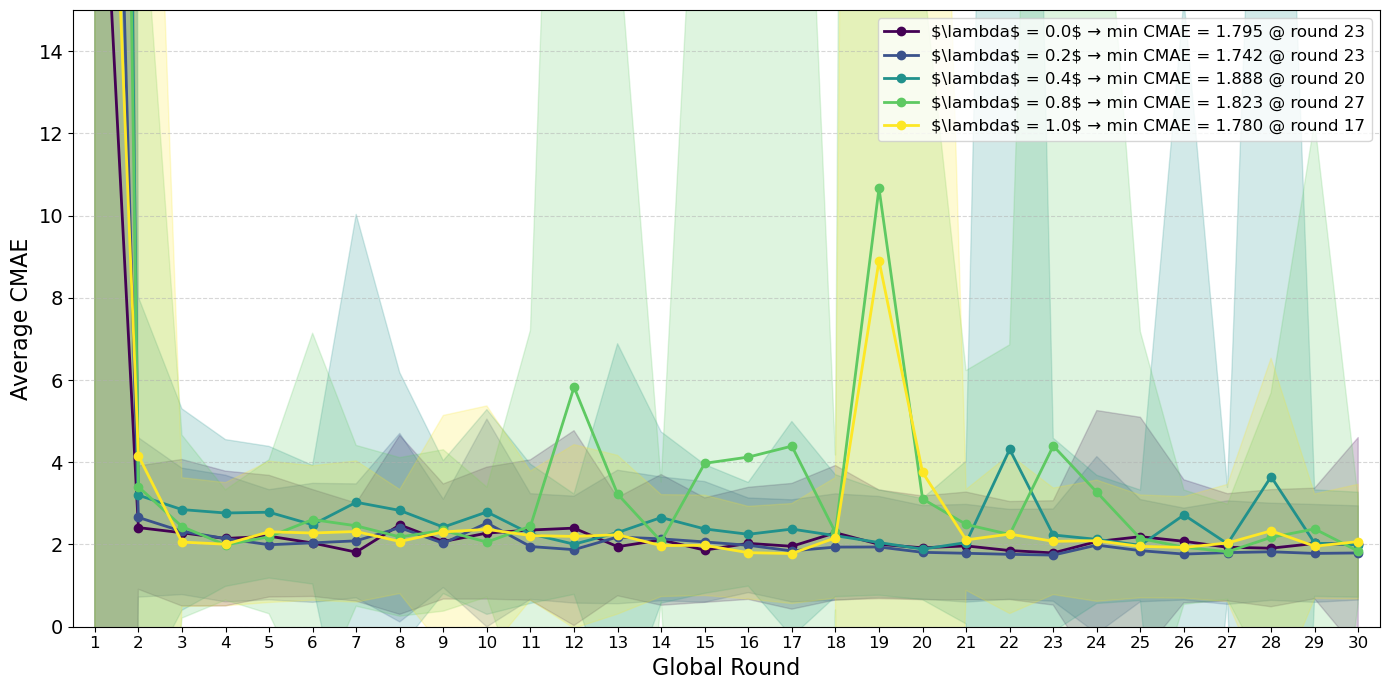

Saved lineplot of average CMAE with std shading (ALL USERS) at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/all_users_avg_cmae_CFedDC_lambda_0_0.2_0.4_0.6_0.8_1_lineplot_minround_STD.png


In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

folders = [
    "CFedDC_lambda_0.0_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.2_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.4_kappa_1.0_delta_1.0",
   # "CFedDC_lambda_0.6_kappa_1.0_delta_1.0",
    "CFedDC_lambda_0.8_kappa_1.0_delta_1.0",
    "CFedDC_lambda_1.0_kappa_1.0_delta_1.0"
]

num_users = 535

# ─── STEP 1: COLLECT DATA ──────────────────────────────────────────────────────
cmae_lists = { folder: [] for folder in folders }

for folder in folders:
    print(f"Processing folder: {folder}")
    for user_id in range(num_users):
        filename = f"user_{user_id}_test_round_results.json"
        file_path = os.path.join(base_dir, folder, "local_test", filename)

        if not os.path.exists(file_path):
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Warning] Could not read {file_path}: {e}")
            continue

        # INCLUDE ALL USERS — NO FILTER
        cmae = data.get("validation_results", {}).get("info_cmae", [])
        if not cmae:
            continue

        cmae_lists[folder].append(cmae)

# ─── STEP 2: ORGANIZE DATA BY ROUND ────────────────────────────────────────────
for folder in folders:
    if len(cmae_lists[folder]) == 0:
        raise RuntimeError(f"No users found for {folder}.")

max_rounds_per_folder = [max(len(lst) for lst in cmae_lists[folder]) for folder in folders]
common_rounds = min(max_rounds_per_folder)
print(f"Common rounds across folders: {common_rounds}")

plot_rounds = common_rounds
print(f"Plotting full range: {plot_rounds} rounds")

by_round = {}
for folder in folders:
    by_round[folder] = [[] for _ in range(common_rounds)]
    for user_list in cmae_lists[folder]:
        for r in range(len(user_list)):
            if r < common_rounds:
                by_round[folder][r].append(user_list[r])

# ─── STEP 3: PLOT AVERAGE CMAE + STD SHADING ───────────────────────────────────
plt.figure(figsize=(14, 7))

rounds = np.arange(1, plot_rounds + 1)

# Use a nice colormap → Viridis
cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(folders)-1)) for i in range(len(folders))]

for idx, folder in enumerate(folders):
    avg_cmae = []
    std_cmae = []
    for r in range(plot_rounds):
        round_values = by_round[folder][r]
        mean_val = np.mean(round_values)
        std_val  = np.std(round_values)
        avg_cmae.append(mean_val)
        std_cmae.append(std_val)

    min_cmae = min(avg_cmae)
    min_round = avg_cmae.index(min_cmae) + 1

    lambda_val = folder.split('_')[2].replace('lambda_', '')
    label = f"$\\lambda$ = {lambda_val}$ → min CMAE = {min_cmae:.3f} @ round {min_round}"

    # Plot average line
    plt.plot(
        rounds,
        avg_cmae,
        label=label,
        color=colors[idx],
        linewidth=2,
        marker='o', markersize=6
    )

    # Plot std shading
    avg_cmae = np.array(avg_cmae)
    std_cmae = np.array(std_cmae)
    plt.fill_between(
        rounds,
        avg_cmae - std_cmae,
        avg_cmae + std_cmae,
        color=colors[idx],
        alpha=0.2
    )

# X-axis
plt.xticks(rounds, [str(r) for r in rounds], fontsize=12)
plt.xlim(0.5, plot_rounds + 0.5)

# Labels
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("Average CMAE", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0, 15.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()

# Save
save_path = os.path.join(base_dir, "all_mae", "all_users_avg_cmae_CFedDC_lambda_0_0.2_0.4_0.6_0.8_1_lineplot_minround_STD.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved lineplot of average CMAE with std shading (ALL USERS) at:\n    {save_path}")


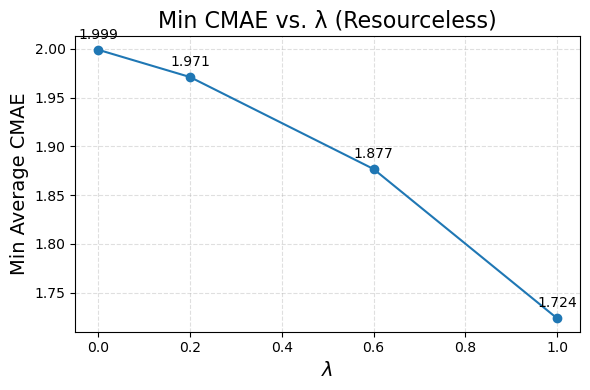